In [1]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=False)

In [2]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [3]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [4]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [5]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [6]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

In [7]:
# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

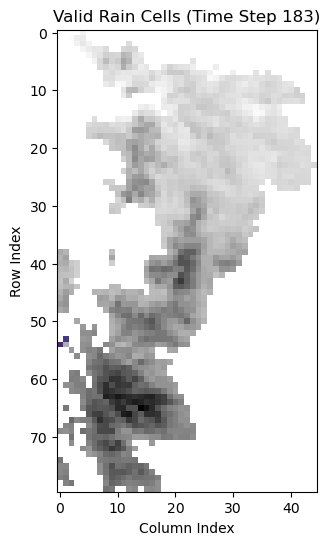

In [8]:
import matplotlib.pyplot as plt

valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

time_step = 183

original_rain_slice = rain[time_step, :, :]  
original_temp_slice = temp[time_step, :, :]

# Visualization
plt.figure(figsize=(10, 6)) 
plt.imshow(original_rain_slice, cmap='viridis')  # Faint background
plt.imshow(original_temp_slice, cmap='gray')  
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Valid Rain Cells (Time Step {})'.format(time_step))
plt.show()

In [9]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]

In [10]:
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [11]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

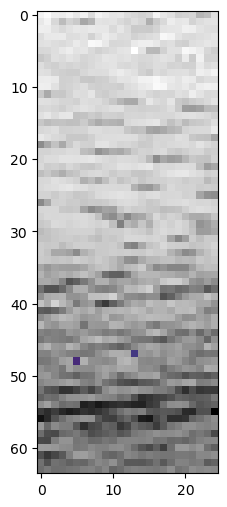

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(valid_rain_data[183,:,:], cmap='viridis')  # Sample timestep
plt.imshow(valid_temp_data[183,:,:], cmap='gray')
plt.show()

In [13]:
def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

In [14]:
rain_tensor = torch.from_numpy(valid_rain_data)
temp_tensor = torch.from_numpy(temp_filled)
hurs_tensor = torch.from_numpy(valid_hurs_data)
frost_tensor = torch.from_numpy(valid_frost_data)
sun_tensor = torch.from_numpy(valid_sun_data)
wind_tensor = torch.from_numpy(wind_filled)
psl_tensor = torch.from_numpy(valid_psl_data)
tmax_tensor = torch.from_numpy(tmax_filled)
tmin_tensor = torch.from_numpy(tmin_filled)

In [15]:
variables = [rain_tensor, temp_tensor, hurs_tensor, frost_tensor, sun_tensor, wind_tensor, psl_tensor, tmax_tensor, tmin_tensor] 

# Stack along the channels dimension (dim=1)
stacked_tensor = torch.stack(variables, dim=1) 

In [16]:
stacked_array = stacked_tensor.numpy() 

print(stacked_array.shape)


(648, 9, 64, 25)


In [17]:
months_pre_1990 = 21 * 12
# Number of months from 1969 to 2022
total_months = (2022 - 1969 + 1) * 12

# Generate labels
labels = np.zeros(total_months, dtype=int)
labels[months_pre_1990:] = 1  # Set post-1990 labels

In [18]:
print("Number of '0' labels (pre-1990):", np.sum(labels == 0))
print("Number of '1' labels (post-1990):", np.sum(labels == 1))

# Check the last label before the change
print("Label of December 1989 (should be 0):", labels[251])  # 252nd month since index starts at 0
# Check the first label after the change
print("Label of January 1990 (should be 1):", labels[252])

print("Total number of months:", len(labels))

Number of '0' labels (pre-1990): 252
Number of '1' labels (post-1990): 396
Label of December 1989 (should be 0): 0
Label of January 1990 (should be 1): 1
Total number of months: 648


In [19]:
import torch

# Convert data and labels to tensors
data_tensor = torch.tensor(stacked_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [20]:
print('Shape of the data',data_tensor.shape)
print('Shape of the labels',labels_tensor.shape)

Shape of the data torch.Size([648, 9, 64, 25])
Shape of the labels torch.Size([648])


In [21]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,  # Sum of input and hidden state dimensions
            out_channels=4 * hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dims, kernel_sizes, num_layers, seq_length, num_classes=2, batch_first=True, bias=True):
        super(ConvLSTM, self).__init__()
        self.seq_length = seq_length
        self.batch_first = batch_first
        self.cell_list = nn.ModuleList()

        cur_input_dim = input_dim
        for i in range(num_layers):
            self.cell_list.append(ConvLSTMCell(cur_input_dim, hidden_dims[i], kernel_sizes[i], bias))
            cur_input_dim = hidden_dims[i]  # Use the hidden dimension as the next layer's input dimension

        self.classifier = nn.Linear(hidden_dims[-1], num_classes)

    def forward(self, x):
        b, seq_len, _, h, w = x.size()
        hidden_states = [cell.init_hidden(b, (h, w)) for cell in self.cell_list]
        
        for time_step in range(seq_len):
            x_t = x[:, time_step, :, :, :]
            for i, cell in enumerate(self.cell_list):
                h, c = hidden_states[i]
                h, c = cell(x_t, (h, c))
                x_t = h  # Output of current cell becomes input to the next

        x_t = x_t.mean(dim=[2, 3])  # Apply global average pooling
        out = self.classifier(x_t)
        return out

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Assuming data_tensor and labels_tensor are already defined
seq_length = 12
num_sequences = data_tensor.shape[0] // seq_length

# Reshape data to [num_sequences, seq_length, channels, height, width]
data_tensor_seq = data_tensor.view(num_sequences, seq_length, data_tensor.shape[1], data_tensor.shape[2], data_tensor.shape[3])

# Assign labels to sequences; each sequence takes the label of its first month
labels_tensor_seq = labels_tensor[0:num_sequences * seq_length:seq_length]  # Pick the first month's label for each sequence

# Create TensorDataset
dataset = TensorDataset(data_tensor_seq, labels_tensor_seq)

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [23]:
print('Input data shape', data_tensor_seq.shape)
print('Labels shape', labels_tensor_seq.shape)

Input data shape torch.Size([54, 12, 9, 64, 25])
Labels shape torch.Size([54])


In [24]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")


batch_size = 16  # Define a suitable batch size

# Create DataLoaders for all datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training dataset size: 37
Validation dataset size: 8
Testing dataset size: 9


In [27]:
import torch    

model = ConvLSTM(seq_length=12, input_dim=9, hidden_dims=[256,128,64],kernel_sizes = [(3,3),(3,3),(3,3)], num_layers=3, num_classes=2)
print(model)

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(265, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


Batch Accuracy: 0.69
Batch Accuracy: 0.50
Batch Accuracy: 0.40
Epoch 1/20, Train Loss: 0.6759, Train Acc: 0.53, Val Loss: 0.6889, Val Acc: 0.50
Batch Accuracy: 0.62
Batch Accuracy: 0.44
Batch Accuracy: 0.80
Epoch 2/20, Train Loss: 0.6563, Train Acc: 0.62, Val Loss: 0.6879, Val Acc: 0.50
Batch Accuracy: 0.50
Batch Accuracy: 0.56
Batch Accuracy: 0.80
Epoch 3/20, Train Loss: 0.6479, Train Acc: 0.62, Val Loss: 0.6880, Val Acc: 0.50
Batch Accuracy: 0.62
Batch Accuracy: 0.50
Batch Accuracy: 0.60
Epoch 4/20, Train Loss: 0.6624, Train Acc: 0.58, Val Loss: 0.6888, Val Acc: 0.50
Batch Accuracy: 0.62
Batch Accuracy: 0.69
Batch Accuracy: 0.00
Epoch 5/20, Train Loss: 0.7068, Train Acc: 0.44, Val Loss: 0.6891, Val Acc: 0.50
Batch Accuracy: 0.44
Batch Accuracy: 0.69
Batch Accuracy: 0.60
Epoch 6/20, Train Loss: 0.6607, Train Acc: 0.58, Val Loss: 0.6880, Val Acc: 0.50
Batch Accuracy: 0.56
Batch Accuracy: 0.69
Batch Accuracy: 0.20
Epoch 7/20, Train Loss: 0.6845, Train Acc: 0.48, Val Loss: 0.6870, Val Ac

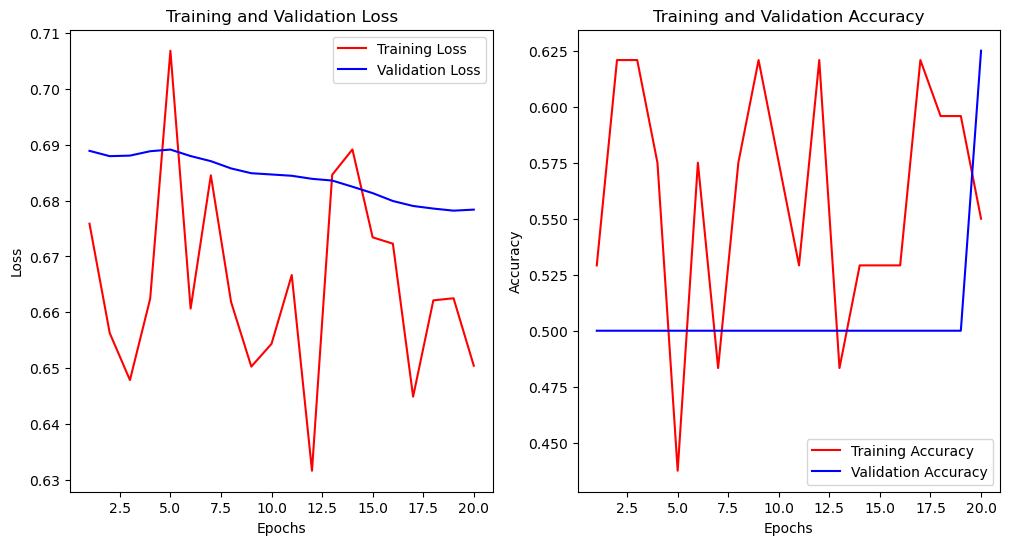

In [29]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Structures to log the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

def calculate_accuracy(output, target):
    _, predicted = torch.max(output.data, 1)
    total = target.size(0)
    correct = (predicted == target).sum().item()
    accuracy = correct / total
    return accuracy

def train_model(num_epochs):
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training Phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            print(f"Batch Accuracy: {accuracy:.2f}")

            total_train_loss += loss.item()
            total_train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        with torch.no_grad():
            for data, labels in val_loader:
                outputs = model(data)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                total_val_accuracy += calculate_accuracy(outputs, labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.2f}')

    print(f'Final Training Accuracy: {train_accuracies[-1]:.2f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.2f}')
    return train_losses, train_accuracies, val_losses, val_accuracies, epoch_times

# Call the training function with the number of epochs
num_epochs = 20
results = train_model(num_epochs)

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Training Loss')
    plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot the metrics
plot_metrics(*results[0:4])

In [28]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.2f}')

# Call the evaluation function with your model and test_loader
evaluate_model(model, test_loader)

Test Accuracy: 0.44


In [30]:
def check_predictions(loader, model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

train_preds, train_labels = check_predictions(train_loader, model)
val_preds, val_labels = check_predictions(val_loader, model)

print("Training predictions:", np.unique(train_preds, return_counts=True))
print("Validation predictions:", np.unique(val_preds, return_counts=True))

Training predictions: (array([1], dtype=int64), array([37], dtype=int64))
Validation predictions: (array([1], dtype=int64), array([8], dtype=int64))


In [29]:
unique, counts = np.unique(train_dataset.dataset.tensors[1], return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(val_dataset.dataset.tensors[1], return_counts=True)
print(dict(zip(unique, counts)))

{0: 21, 1: 33}
{0: 21, 1: 33}


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'model' and 'device' are defined
model.eval()  # Set the model to evaluation mode

device = torch.device("cpu")
model.to(device)

def get_predictions_and_labels(model, loader):
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)  # Send input to the same device as model
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            all_probs.extend(probabilities[:, 0].cpu().numpy())  # Assuming class '1' is the positive class
            all_labels.extend(labels.cpu().numpy())
    return all_probs, all_labels

# Get predictions and labels
train_probs, train_labels = get_predictions_and_labels(model, train_loader)
test_probs, test_labels = get_predictions_and_labels(model, test_loader)

# Calculate ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(train_labels, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train AUC = {:.2f}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test AUC = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))